**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [307]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from scipy.optimize import minimize


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [394]:
import sympy as sm

# Define the symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
v = sm.symbols('v')
w = sm.symbols('w')
tau = sm.symbols('tau')
L = sm.symbols('L')
G = sm.symbols('G')
C = sm.symbols('C')
w_tilde = sm.symbols('w_tilde')

# w_tilde = (1-tau)*wc

# Define the utility function
utility = sm.log(C**alpha * G**(1-alpha)) - v*(L**2)/2

# Define the constraint
constraint = sm.Eq(C, kappa + w_tilde*L)

# Substitute the constraint into the utility function
complete = utility.subs(C, constraint.rhs)

dU_dL = sm.diff(complete, L)
FOC = sm.Eq(0, dU_dL)

# Add L*v to both sides of FOC
FOC_updated = sm.Eq(FOC.lhs + L*v, FOC.rhs + L*v)
FOC_updated = sm.Eq(FOC_updated.lhs * (L*w_tilde + kappa), FOC_updated.rhs * (L*w_tilde + kappa))
FOC_updated = sm.Eq(FOC_updated.lhs, FOC_updated.rhs - G**(1-alpha)*G**(alpha-1)*alpha*w_tilde + alpha * w_tilde)
FOC_updated = sm.Eq(FOC_updated.lhs - alpha * w_tilde, FOC_updated.rhs - alpha * w_tilde)

# Display the updated FOC equation
FOC_updated


Eq(L*v*(L*w_tilde + kappa) - alpha*w_tilde, 0)

We can from the above result see that it gives the following polynomial equation:

$L^2 * w_tilde + L * kappa - alpha/v * w_tilde$

In [395]:
a = w_tilde
b = kappa
c = alpha/v * w_tilde
d = b**2 - 4*a*c

L = (-b + sm.sqrt(d))/(2*a)
L

(-kappa + sqrt(-4*alpha*w_tilde**2/v + kappa**2))/(2*w_tilde)

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In this question we will take the $L^{\star}(\tilde{w})$ that we found from the question above and insert the $\tilde{w} = (1-\tau)w$. We then plot the graph to see how the optimal labor supply depends on wage:

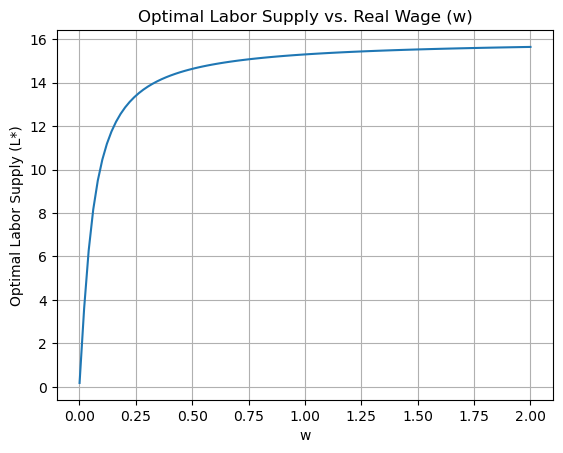

In [309]:
# Insert the relevant values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.30

w_values = np.linspace(0.001, 2.0, 100)  # Range of w values to plot
tilde_w_values = (1 - tau) * w_values    # make w_tilde

# Insert the optimal labor supply function
optimal_labor = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w_values**2)) / (2 * tilde_w_values)

# Plotting the optimal labor supply function with the real wage values between 0 to 2
plt.plot(w_values, optimal_labor)
plt.xlabel('w')
plt.ylabel('Optimal Labor Supply (L*)')
plt.title('Optimal Labor Supply vs. Real Wage (w)')
plt.grid(True)
plt.show()


We can see that it is a logarithmic function where it goes towards 16 in optimal labor supply when w goes towards unlimited.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


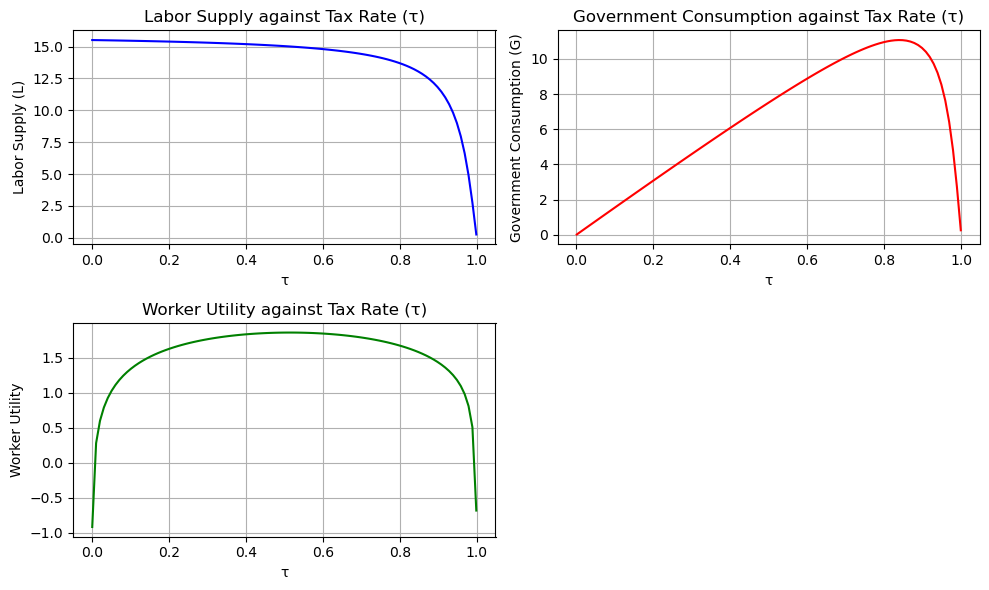

In [310]:
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

tau_v = np.linspace(0.001, 0.999, 100)  # Grid of tau values

lab_s = []
gov_c = []
work_u = []

for tau in tau_v:
    tilde_w = (1 - tau) * w
    optimal_labor = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w**2)) / (2 * tilde_w)
    lab_s.append(optimal_labor)
    government_spending = tau * w * optimal_labor
    gov_c.append(government_spending)
    utility = np.log((kappa + (1 - tau) * w * optimal_labor)**alpha * government_spending**(1 - alpha)) - (nu * optimal_labor**2) / 2
    work_u.append(utility)

# Plotting
plt.figure(figsize=(10, 6))

# Labor Supply
plt.subplot(2, 2, 1)
plt.plot(tau_v, lab_s, color='blue')
plt.xlabel('τ')
plt.ylabel('Labor Supply (L)')
plt.title('Labor Supply against Tax Rate (τ)')
plt.grid(True)

# Government Consumption
plt.subplot(2, 2, 2)
plt.plot(tau_v, gov_c, color='red')
plt.xlabel('τ')
plt.ylabel('Government Consumption (G)')
plt.title('Government Consumption against Tax Rate (τ)')
plt.grid(True)

# Worker Utility
plt.subplot(2, 2, 3)
plt.plot(tau_v, work_u, color='green')
plt.xlabel('τ')
plt.ylabel('Worker Utility')
plt.title('Worker Utility against Tax Rate (τ)')
plt.grid(True)

plt.tight_layout()
plt.show()


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

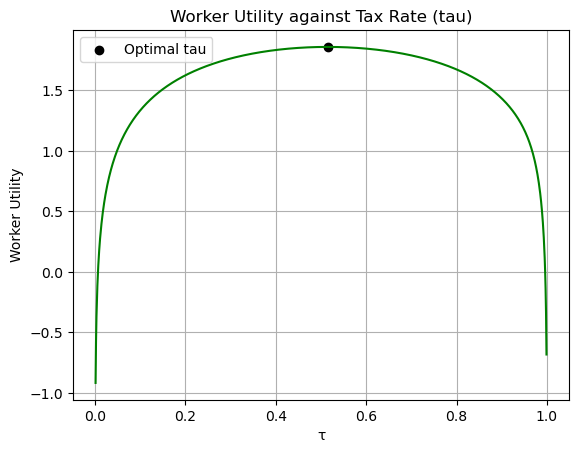

Optimal tax rate (tau): 0.51
Maximized worker utility: 1.86


In [311]:
# Setting the parameters values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

tau_v = np.linspace(0.001, 0.999, 1000)  # Grid of tau values

# Making empty array
worker_u = []

# finding the worker utility when running through the different tau_v between 0 and 1
for tau in tau_v:
    tilde_w = (1 - tau) * w
    optimal_l = (-kappa + np.sqrt(kappa**2 + 4 * (alpha / nu) * tilde_w**2)) / (2 * tilde_w)
    government_spending = tau * w * optimal_l
    utility = np.log((kappa + (1 - tau) * w * optimal_l)**alpha * government_spending**(1 - alpha)) - (nu * optimal_l**2) / 2
    worker_u.append(utility)

# Finding the socially optimal tax rate
optimal_tau_index = np.argmax(worker_u)
optimal_tau = tau_v[optimal_tau_index]
optimal_utility = worker_u[optimal_tau_index]

# Plotting the worker utility against tax rate, tau.
plt.plot(tau_v, worker_u, color='green')
plt.scatter(optimal_tau, optimal_utility, color='black', label='Optimal tau')
plt.xlabel('τ')
plt.ylabel('Worker Utility')
plt.title('Worker Utility against Tax Rate (tau)')
plt.legend()
plt.grid(True)
plt.show()

print("Optimal tax rate (tau): {:.2f}".format(optimal_tau))
print("Maximized worker utility: {:.2f}".format(optimal_utility))


We then find that the optimal tax rate is $0.51$ and that gives the worker utility of $1.86$

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [312]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [313]:
# write your code here

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [314]:
eta = 0.5
w = 1.0
kappa_values = [1.0, 2.0]

for kappa_t in kappa_values:
    optimal_lt = ((1 - eta) * kappa_t / w) ** (1 / eta)
    profit = kappa_t * optimal_lt ** (1 - eta) - w * optimal_lt
    print(f"Profit for kappa_t = {kappa_t}: {profit}, optimal lt: {optimal_lt}")


Profit for kappa_t = 1.0: 0.25, optimal lt: 0.25
Profit for kappa_t = 2.0: 1.0, optimal lt: 1.0


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [315]:
import numpy as np

eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

K = 1000  # Number of shock series to simulate
np.random.seed(0)  # Set random seed for reproducibility

# Function to calculate salon value for a given shock series
def calculate_salon_value(shock_series):
    kappa_t_prev = 1.0  # Initial demand shock
    lt_prev = 0.0  # Initial number of employees
    salon_value = 0.0

    for t in range(120):
        kappa_t = rho * kappa_t_prev + shock_series[t]
        lt = ((1 - eta) * kappa_t / w) ** (1 / eta)

        profit = kappa_t * lt ** (1 - eta) - w * lt - (lt != lt_prev) * iota
        discounted_profit = profit * R ** (-t)
        salon_value += discounted_profit

        kappa_t_prev = kappa_t  # Update for the next period
        lt_prev = lt  # Update for the next period

    return salon_value

# Monte Carlo simulation
salon_values = np.zeros(K)

for k in range(K):
    shock_series = np.random.normal(-0.5 * sigma_epsilon ** 2, sigma_epsilon, size=120)
    salon_values[k] = calculate_salon_value(shock_series)

H = np.mean(salon_values)
H


-1.9426039956918206

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [316]:
import numpy as np

# Set the parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
delta = 0.05

# Number of shock series to simulate
K = 1000

# Initialize the objective function values list
objective_values = []

# Perform the simulation
for k in range(K):
    # Set the initial values
    kappa_t_minus_1 = 1.0
    ell_t_minus_1 = 0
    
    # Generate the demand shocks
    epsilon = np.random.normal(loc=-0.5 * sigma_epsilon ** 2, scale=sigma_epsilon, size=120)
    
    # Initialize the objective function value for the current shock series
    objective_value = 0.0
    
    # Iterate over time periods
    for t in range(120):
        # Calculate the demand shock for the current period
        kappa_t = np.exp(rho * np.log(kappa_t_minus_1) + epsilon[t])
        
        # Calculate the optimal employment level
        ell_t_ast = ((1 - eta) * kappa_t / w) ** (1 / eta)
        
        # Check if the employment level should be adjusted
        if abs(ell_t_minus_1 - ell_t_ast) > delta:
            ell_t = ell_t_ast
        else:
            ell_t = ell_t_minus_1
        
        # Calculate the profit for the current period
        profit = kappa_t * ell_t ** (1 - eta) - w * ell_t - int(ell_t != ell_t_minus_1) * iota
        
        # Discount the profit
        profit_discounted = R ** t * profit
        
        # Add the discounted profit to the objective function value
        objective_value += profit_discounted
        
        # Update the variables for the next period
        kappa_t_minus_1 = kappa_t
        ell_t_minus_1 = ell_t
    
    # Add the objective function value for the current shock series to the list
    objective_values.append(objective_value)

# Calculate H as the average of the objective function values
H = np.mean(objective_values)

print("H with delta =", delta, ": ", H)

H with delta = 0.05 :  31.228913289452198


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

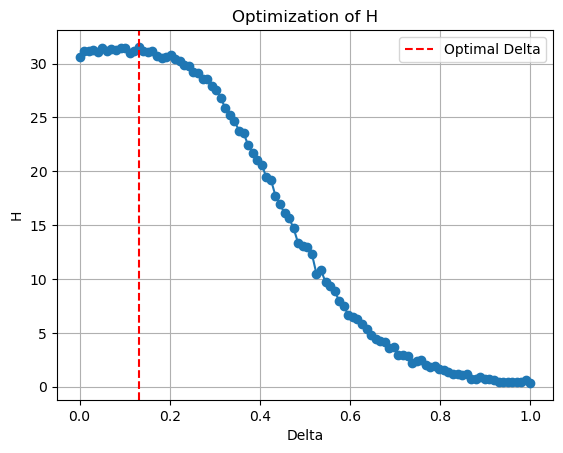

Optimal Delta: 0.13131313131313133
Maximized H: 31.54544412980094


In [317]:
import numpy as np

# Set the parameter values
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)

# Number of shock series to simulate
K = 1000

# Define the range of Delta values to consider
delta_values = np.linspace(0, 1, 100)

# Initialize the dictionary to store the results
results = {}

# Perform the search for the optimal Delta
for delta in delta_values:
    # Initialize the objective function values list
    objective_values = []
    
    # Perform the simulation
    for k in range(K):
        # Set the initial values
        kappa_t_minus_1 = 1.0
        ell_t_minus_1 = 0
    
        # Generate the demand shocks
        epsilon = np.random.normal(loc=-0.5 * sigma_epsilon ** 2, scale=sigma_epsilon, size=120)
    
        # Initialize the objective function value for the current shock series
        objective_value = 0.0
    
        # Iterate over time periods
        for t in range(120):
            # Calculate the demand shock for the current period
            kappa_t = np.exp(rho * np.log(kappa_t_minus_1) + epsilon[t])
        
            # Calculate the optimal employment level
            ell_t_ast = ((1 - eta) * kappa_t / w) ** (1 / eta)
        
            # Check if the employment level should be adjusted
            if abs(ell_t_minus_1 - ell_t_ast) > delta:
                ell_t = ell_t_ast
            else:
                ell_t = ell_t_minus_1
        
            # Calculate the profit for the current period
            profit = kappa_t * ell_t ** (1 - eta) - w * ell_t - int(ell_t != ell_t_minus_1) * iota
        
            # Discount the profit
            profit_discounted = R ** t * profit
        
            # Add the discounted profit to the objective function value
            objective_value += profit_discounted
        
            # Update the variables for the next period
            kappa_t_minus_1 = kappa_t
            ell_t_minus_1 = ell_t
        objective_values.append(objective_value)
    
        # Calculate H as the average of the objective function values
        H = np.mean(objective_values)
    
    # Store the result
    results[delta] = H

# Find the optimal Delta that maximizes H
optimal_delta = max(results, key=results.get)
max_H = results[optimal_delta]

# Plot the results
plt.plot(delta_values, list(results.values()), marker='o')
plt.xlabel('Delta')
plt.ylabel('H')
plt.title('Optimization of H')
plt.axvline(x=optimal_delta, color='r', linestyle='--', label='Optimal Delta')
plt.legend()
plt.grid(True)
plt.show()

print("Optimal Delta:", optimal_delta)
print("Maximized H:", max_H)


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [318]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [319]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [320]:
def refined_global_optimizer(bounds, tolerance, lower_K, upper_K):
    x_best = None
    f_best = np.inf

    for k in range(upper_K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= lower_K:
            chi_k = 0.5 * (2 / (1 + np.exp((k - lower_K) / 100)))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_best
            x0 = x_k0
        else:
            x0 = x_k

        result = minimize(griewank, x0, method='BFGS', tol=tolerance)
        x_k_ast = result.x
        f_k_ast = result.fun

        if k == 0 or f_k_ast < f_best:
            x_best = x_k_ast
            f_best = f_k_ast

        if f_best < tolerance:
            break

        print(f"Iteration {k}: x_k0 = {x0}, f_k_ast = {f_k_ast}")

    return x_best

# Settings
bounds = [-600, 600]
tolerance = 1e-8
lower_K = 10
upper_K = 1000

# Run the optimizer
x_ast = refined_global_optimizer(bounds, tolerance, lower_K, upper_K)

print("Optimization Result:")
print(f"x_ast = {x_ast}, f(x_ast) = {griewank(x_ast)}")

Iteration 0: x_k0 = [310.55683381 318.64851655], f_k_ast = 49.02195263645098
Iteration 1: x_k0 = [-518.43262758  270.92630286], f_k_ast = 85.48456313600137
Iteration 2: x_k0 = [322.66051758 506.81456717], f_k_ast = 89.7249640847331
Iteration 3: x_k0 = [-571.03833628 -566.28724114], f_k_ast = 57.058596377525596
Iteration 4: x_k0 = [ 385.84694714 -501.17227659], f_k_ast = 100.25811013507123
Iteration 5: x_k0 = [ -27.15778135 -205.1449282 ], f_k_ast = 10.589425549032233
Iteration 6: x_k0 = [-295.99047106  295.26808294], f_k_ast = 43.26524116588751
Iteration 7: x_k0 = [-259.04106306  365.21710478], f_k_ast = 49.73048441620147
Iteration 8: x_k0 = [-217.19347687  -49.74233163], f_k_ast = 12.337931128193777
Iteration 9: x_k0 = [-223.11151304 -494.86717975], f_k_ast = 73.1718463370828
Iteration 10: x_k0 = [ 181.00578021 -145.09818153], f_k_ast = 13.381181578876271
Iteration 11: x_k0 = [-129.73968443 -210.7802779 ], f_k_ast = 15.035672848862813
Iteration 12: x_k0 = [-200.74428806  -37.14658537]

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [321]:
def refined_global_optimizer(bounds, tolerance, lower_K, upper_K):
    x_best = None
    f_best = np.inf

    for k in range(upper_K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= lower_K:
            chi_k = 0.5 * (2 / (1 + np.exp((k - lower_K) / 100)))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_best
            x0 = x_k0
        else:
            x0 = x_k

        result = minimize(griewank, x0, method='BFGS', tol=tolerance)
        x_k_ast = result.x
        f_k_ast = result.fun

        if k == 0 or f_k_ast < f_best:
            x_best = x_k_ast
            f_best = f_k_ast

        if f_best < tolerance:
            break

        print(f"Iteration {k}: x_k0 = {x0}, f_k_ast = {f_k_ast}")

    return x_best

# Settings
bounds = [-600, 600]
tolerance = 1e-8

# Run the optimizer with lower_K = 10
lower_K_10 = 10
upper_K = 1000
x_ast_lower_K_10 = refined_global_optimizer(bounds, tolerance, lower_K_10, upper_K)

# Run the optimizer with lower_K = 100
lower_K_100 = 100
x_ast_lower_K_100 = refined_global_optimizer(bounds, tolerance, lower_K_100, upper_K)

print("Optimization Result (lower_K = 10):")
print(f"x_ast = {x_ast_lower_K_10}, f(x_ast) = {griewank(x_ast_lower_K_10)}")

print("Optimization Result (lower_K = 100):")
print(f"x_ast = {x_ast_lower_K_100}, f(x_ast) = {griewank(x_ast_lower_K_100)}")


Iteration 0: x_k0 = [-86.54460881  -2.77370403], f_k_ast = 1.8027662171362295
Iteration 1: x_k0 = [-198.34806632  208.80325512], f_k_ast = 20.678230460487924
Iteration 2: x_k0 = [-223.46807029   16.4514245 ], f_k_ast = 12.476315085227782
Iteration 3: x_k0 = [537.88926015 122.54253763], f_k_ast = 75.70673479493425
Iteration 4: x_k0 = [ 325.36164121 -309.25222168], f_k_ast = 50.82997819810325
Iteration 5: x_k0 = [ 63.0756652  128.80473258], f_k_ast = 5.233597540503339
Iteration 6: x_k0 = [-558.84053522 -286.27449206], f_k_ast = 98.32962905185965
Iteration 7: x_k0 = [  71.05567339 -189.28403224], f_k_ast = 10.419916822639221
Iteration 8: x_k0 = [-162.01781311 -110.45895129], f_k_ast = 9.49565995609097
Iteration 9: x_k0 = [ 6.91243229 86.97611274], f_k_ast = 1.981812946039153
Iteration 10: x_k0 = [-107.23870878 -219.17964345], f_k_ast = 15.17552734259749
Iteration 11: x_k0 = [  23.83440509 -268.81728964], f_k_ast = 17.90532073989996
Iteration 12: x_k0 = [-228.89016259 -190.41915049], f_k_a

Both settings of lower_k have successfully found the global minimum of the Griewank function. This is found to be f(0,0)=0. We can here see that lower_k=10 gives the function value of zero, but where the lower_k=100 gives a global minimum close to zero, but not zero. By lowering the value of lower_k it has been seen that it gives a better precision in finding the global minimum.

Overall, the refined global optimizer with multi-start has successfully converged to the global minimum of the Griewank function, and decreasing the value of lower_K to 10 has improved the precision slightly but did not significantly affect the final optimization outcome.